# DAY 45 Tensorborad

之前的内容中，我们在神经网络训练中，为了帮助自己理解，借用了很多的组件，比如训练进度条、可视化的loss下降曲线、权重分布图，运行结束后还可以查看单张图的推理效果。

如果现在有一个交互工具可以很简单的通过按钮完成这些辅助功能那就好了。所以我们现在介绍下tensorboard这个可视化工具，他可以很方便的很多可视化的功能，尤其是他可以在运行过程中实时渲染，方便我们根据图来动态调整训练策略，而不是训练完了才知道好不好。



## 一、tensorboard的基本操作

### 1.1 发展历史

TensorBoard 是 TensorFlow 生态中的官方可视化工具（也可无缝集成 PyTorch），用于实时监控训练过程、可视化模型结构、分析数据分布、对比实验结果等。它通过网页端交互界面，将枯燥的训练日志转化为直观的图表和图像，帮助开发者快速定位问题、优化模型。

简单来说，TensorBoard 是 TensorFlow 自带的一个「可视化工具」，就像给机器学习模型训练过程装了一个「监控屏幕」。你可以用它直观看到训练过程中的数据变化（比如损失值、准确率）、模型结构、数据分布等，不用盯着一堆枯燥的数字看，对新手非常友好。

TensorBoard 的发展历程如下：
- 2015 年随着 TensorFlow 框架一起发布，最初是为了满足深度学习研究者可视化复杂模型训练过程的需求。2016-2018 年新增了更多可视化功能，图像 / 音频可视化：可以直接看训练数据里的图片、听音频（比如在图像分类任务中，查看输入的图片是否正确）。
直方图：展示数据分布（比如权重参数的分布是否合理）。
多运行对比：同时对比多个训练任务的结果（比如不同学习率的效果对比）。

- 2019 年后与 PyTorch 兼容，变得更通用了。功能进一步丰富，比如支持3D 可视化、模型参数调试等。

目前这个工具还在不断发展，比如一些额外功能在tensorboardX上存在，但是我们目前只需要要用到最经典的几个功能即可

1. 保存模型结构图
2. 保存训练集和验证集的loss变化曲线，不需要手动打印了
3. 保存每一个层结构权重分布
4. 保存预测图片的预测信息


### 1.2 tensorboard的原理

TensorBoard 的核心原理就是在训练过程中，把训练过程中的数据（比如损失、准确率、图片等）先记录到日志文件里，再通过工具把这些日志文件可视化成图表，这样就不用自己手动打印数据或者用其他工具画图。

所以核心就是2个步骤：
- 数据怎么存？—— 先写日志文件

训练模型时，TensorBoard 会让程序把训练数据（比如损失值、准确率）和模型结构等信息，写入一个特殊的日志文件（.tfevents 文件）

- 数据怎么看？—— 用网页展示日志

写完日志后，TensorBoard 会启动一个本地网页服务，自动读取日志文件里的数据，用图表、图像、文本等形式展示出来。如果只用 print(损失值) 或者自己用 matplotlib 画图，不仅麻烦，还得手动保存数据、写代码，尤其训练几天几夜时，根本没法实时盯着看。而 TensorBoard 能自动把这些数据 “存下来 + 画出来”，还能生成网页版的可视化界面，随时刷新查看！


In [ ]:
# pip install tensorboard -i https://pypi.tuna.tsinghua.edu.cn/simple

下面是tensorboard的核心代码解析，无需运行 看懂大概在做什么即可

### 1.3  日志目录自动管理

In [ ]:
log_dir = 'runs/cifar10_mlp_experiment'
if os.path.exists(log_dir):
    i = 1
    while os.path.exists(f"{log_dir}_{i}"):
        i += 1
    log_dir = f"{log_dir}_{i}"
writer = SummaryWriter(log_dir) #关键入口，用于写入数据到日志目录

自动避免日志目录重复。若 runs/cifar10_mlp_experiment 已存在，会生成 runs/cifar10_mlp_experiment_1、_2 等新目录，确保每次训练的日志独立存储。

方便对比不同训练任务的结果（如不同超参数实验）

### 1.4 记录标量数据（Scalar）



In [ ]:
# 记录每个 Batch 的损失和准确率
writer.add_scalar('Train/Batch_Loss', batch_loss, global_step)
writer.add_scalar('Train/Batch_Accuracy', batch_acc, global_step)

# 记录每个 Epoch 的训练指标
writer.add_scalar('Train/Epoch_Loss', epoch_train_loss, epoch)
writer.add_scalar('Train/Epoch_Accuracy', epoch_train_acc, epoch)

在 tensorboard的SCALARS 选项卡中查看曲线，支持多 run 对比。

### 1.5 可视化模型结构（Graph）

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.to(device)
writer.add_graph(model, images)  # 通过真实输入样本生成模型计算图

TensorBoard 界面：在 GRAPHS 选项卡中查看模型层次结构（卷积层、全连接层等）。

### 1.6 可视化图像（Image）

In [ ]:
# 可视化原始训练图像
img_grid = torchvision.utils.make_grid(images[:8].cpu()) # 将多张图像拼接成网格状（方便可视化），将前8张图像拼接成一个网格
writer.add_image('原始训练图像', img_grid)

# 可视化错误预测样本（训练结束后）
wrong_img_grid = torchvision.utils.make_grid(wrong_images[:display_count])
writer.add_image('错误预测样本', wrong_img_grid)

展示原始图像、数据增强效果、错误预测样本等。

### 1.7 记录权重和梯度直方图（Histogram）

In [ ]:
if (batch_idx + 1) % 500 == 0:
    for name, param in model.named_parameters():
        writer.add_histogram(f'weights/{name}', param, global_step)  # 权重分布
        if param.grad is not None:
            writer.add_histogram(f'grads/{name}', param.grad, global_step)  # 梯度分布

在 HISTOGRAMS 选项卡中查看不同层的参数分布随训练的变化。监控模型参数（如权重 weights）和梯度（grads）的分布变化，诊断训练问题（如梯度消失 / 爆炸）。

### 1.8 启动tensorboard

运行代码后，会在指定目录（如 runs/cifar10_mlp_experiment_1）生成 .tfevents 文件，存储所有 TensorBoard 数据。

在终端执行（需进入项目根目录）：

tensorboard --logdir=runs  # 假设日志目录在 runs/ 下

打开浏览器，输入终端提示的 URL（通常为 http://localhost:6006）。

## 二、tensorboard实战

### 2.1 cifar-10 MLP实战

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置随机种子以确保结果可复现
torch.manual_seed(42)
np.random.seed(42)

# 1. 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),                # 转换为张量
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化处理
])

# 2. 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=transform
)

# 3. 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CIFAR-10的类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 4. 定义MLP模型（适应CIFAR-10的输入尺寸）
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()  # 将3x32x32的图像展平为3072维向量
        self.layer1 = nn.Linear(3072, 512)  # 第一层：3072个输入，512个神经元
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)  # 添加Dropout防止过拟合
        self.layer2 = nn.Linear(512, 256)  # 第二层：512个输入，256个神经元
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(256, 10)  # 输出层：10个类别
        
    def forward(self, x):
        # 第一步：将输入图像展平为一维向量
        x = self.flatten(x)  # 输入尺寸: [batch_size, 3, 32, 32] → [batch_size, 3072]
        
        # 第一层全连接 + 激活 + Dropout
        x = self.layer1(x)   # 线性变换: [batch_size, 3072] → [batch_size, 512]
        x = self.relu1(x)    # 应用ReLU激活函数
        x = self.dropout1(x) # 训练时随机丢弃部分神经元输出
        
        # 第二层全连接 + 激活 + Dropout
        x = self.layer2(x)   # 线性变换: [batch_size, 512] → [batch_size, 256]
        x = self.relu2(x)    # 应用ReLU激活函数
        x = self.dropout2(x) # 训练时随机丢弃部分神经元输出
        
        # 第三层（输出层）全连接
        x = self.layer3(x)   # 线性变换: [batch_size, 256] → [batch_size, 10]
        
        return x  # 返回未经过Softmax的logits

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = MLP()
model = model.to(device)  # 将模型移至GPU（如果可用）

criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 创建TensorBoard的SummaryWriter，指定日志保存目录
log_dir = 'runs/cifar10_mlp_experiment'
# 如果目录已存在，添加后缀避免覆盖
if os.path.exists(log_dir):
    i = 1
    while os.path.exists(f"{log_dir}_{i}"):
        i += 1
    log_dir = f"{log_dir}_{i}"
writer = SummaryWriter(log_dir)

# 5. 训练模型（使用TensorBoard记录各种信息）
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs, writer):
    model.train()  # 设置为训练模式
    
    # 记录训练开始时间，用于计算训练速度
    global_step = 0
    
    # 可视化模型结构
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    writer.add_graph(model, images)  # 添加模型图
    
    # 可视化原始图像样本
    img_grid = torchvision.utils.make_grid(images[:8].cpu())
    writer.add_image('原始训练图像', img_grid)
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)  # 移至GPU
            
            optimizer.zero_grad()  # 梯度清零
            output = model(data)  # 前向传播
            loss = criterion(output, target)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            
            # 统计准确率和损失
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # 每100个批次记录一次信息到TensorBoard
            if (batch_idx + 1) % 100 == 0:
                batch_loss = loss.item()
                batch_acc = 100. * correct / total
                
                # 记录标量数据（损失、准确率）
                writer.add_scalar('Train/Batch_Loss', batch_loss, global_step)
                writer.add_scalar('Train/Batch_Accuracy', batch_acc, global_step)
                
                # 记录学习率
                writer.add_scalar('Train/Learning_Rate', optimizer.param_groups[0]['lr'], global_step)
                
                # 每500个批次记录一次直方图（权重和梯度）
                if (batch_idx + 1) % 500 == 0:
                    for name, param in model.named_parameters():
                        writer.add_histogram(f'weights/{name}', param, global_step)
                        if param.grad is not None:
                            writer.add_histogram(f'grads/{name}', param.grad, global_step)
                
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
                      f'| 单Batch损失: {batch_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')
            
            global_step += 1
        
        # 计算当前epoch的平均训练损失和准确率
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        
        # 记录每个epoch的训练损失和准确率
        writer.add_scalar('Train/Epoch_Loss', epoch_train_loss, epoch)
        writer.add_scalar('Train/Epoch_Accuracy', epoch_train_acc, epoch)
        
        # 测试阶段
        model.eval()  # 设置为评估模式
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        # 用于存储预测错误的样本
        wrong_images = []
        wrong_labels = []
        wrong_preds = []
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
                
                # 收集预测错误的样本
                wrong_mask = (predicted != target).cpu()
                if wrong_mask.sum() > 0:
                    wrong_batch_images = data[wrong_mask].cpu()
                    wrong_batch_labels = target[wrong_mask].cpu()
                    wrong_batch_preds = predicted[wrong_mask].cpu()
                    
                    wrong_images.extend(wrong_batch_images)
                    wrong_labels.extend(wrong_batch_labels)
                    wrong_preds.extend(wrong_batch_preds)
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        
        # 记录每个epoch的测试损失和准确率
        writer.add_scalar('Test/Loss', epoch_test_loss, epoch)
        writer.add_scalar('Test/Accuracy', epoch_test_acc, epoch)
        
        # 计算并记录训练速度（每秒处理的样本数）
        # 这里简化处理，假设每个epoch的时间相同
        samples_per_epoch = len(train_loader.dataset)
        # 实际应用中应该使用time.time()来计算真实时间
        
        print(f'Epoch {epoch+1}/{epochs} 完成 | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')
        
        # 可视化预测错误的样本（只在最后一个epoch进行）
        if epoch == epochs - 1 and len(wrong_images) > 0:
            # 最多显示8个错误样本
            display_count = min(8, len(wrong_images))
            wrong_img_grid = torchvision.utils.make_grid(wrong_images[:display_count])
            
            # 创建错误预测的标签文本
            wrong_text = []
            for i in range(display_count):
                true_label = classes[wrong_labels[i]]
                pred_label = classes[wrong_preds[i]]
                wrong_text.append(f'True: {true_label}, Pred: {pred_label}')
            
            writer.add_image('错误预测样本', wrong_img_grid)
            writer.add_text('错误预测标签', '\n'.join(wrong_text), epoch)
    
    # 关闭TensorBoard写入器
    writer.close()
    
    return epoch_test_acc  # 返回最终测试准确率

# 6. 执行训练和测试
epochs = 20  # 训练轮次
print("开始训练模型...")
print(f"TensorBoard日志保存在: {log_dir}")
print("训练完成后，使用命令 `tensorboard --logdir=runs` 启动TensorBoard查看可视化结果")

final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, device, epochs, writer)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

Files already downloaded and verified
开始训练模型...
TensorBoard日志保存在: runs/cifar10_mlp_experiment_1
训练完成后，使用命令 `tensorboard --logdir=runs` 启动TensorBoard查看可视化结果
Epoch: 1/20 | Batch: 100/782 | 单Batch损失: 1.8327 | 累计平均损失: 1.9410
Epoch: 1/20 | Batch: 200/782 | 单Batch损失: 1.8588 | 累计平均损失: 1.8519
Epoch: 1/20 | Batch: 300/782 | 单Batch损失: 1.6719 | 累计平均损失: 1.8029
Epoch: 1/20 | Batch: 400/782 | 单Batch损失: 1.7609 | 累计平均损失: 1.7754
Epoch: 1/20 | Batch: 500/782 | 单Batch损失: 1.6642 | 累计平均损失: 1.7508
Epoch: 1/20 | Batch: 600/782 | 单Batch损失: 1.6564 | 累计平均损失: 1.7330
Epoch: 1/20 | Batch: 700/782 | 单Batch损失: 1.5870 | 累计平均损失: 1.7199
Epoch 1/20 完成 | 训练准确率: 39.23% | 测试准确率: 45.11%
Epoch: 2/20 | Batch: 100/782 | 单Batch损失: 1.4987 | 累计平均损失: 1.5227
Epoch: 2/20 | Batch: 200/782 | 单Batch损失: 1.3297 | 累计平均损失: 1.4918
Epoch: 2/20 | Batch: 300/782 | 单Batch损失: 1.3329 | 累计平均损失: 1.4820
Epoch: 2/20 | Batch: 400/782 | 单Batch损失: 1.5894 | 累计平均损失: 1.4701
Epoch: 2/20 | Batch: 500/782 | 单Batch损失: 1.3843 | 累计平均损失: 1.4710
Epoch: 2/20 | Batc

TensorBoard日志保存在: runs/cifar10_mlp_experiment_1
可以在命令行中进入目前的环境，然后通过tensorboard --logdir=xxxx（目录）即可调出本地链接，点进去就是目前的训练信息，可以不断F5刷新来查看变化。



在TensorBoard界面中，你可以看到：

1. SCALARS 选项卡：展示损失曲线、准确率变化、学习率等标量数据----Scalar意思是标量，指只有大小、没有方向的量。

2. IMAGES 选项卡：展示原始训练图像和错误预测的样本

3. GRAPHS 选项卡：展示模型的计算图结构

4. HISTOGRAMS 选项卡：展示模型参数和梯度的分布直方图

### 2.2 cifar-10 CNN实战 

使用设备: cuda
Files already downloaded and verified
开始使用CNN训练模型...
TensorBoard 日志目录: runs/cifar10_cnn_exp
训练后执行: tensorboard --logdir=runs 查看可视化
Epoch: 1/20 | Batch: 100/782 | 单Batch损失: 1.8809 | 累计平均损失: 2.0134
Epoch: 1/20 | Batch: 200/782 | 单Batch损失: 1.7645 | 累计平均损失: 1.8838
Epoch: 1/20 | Batch: 300/782 | 单Batch损失: 1.6334 | 累计平均损失: 1.8246
Epoch: 1/20 | Batch: 400/782 | 单Batch损失: 1.6380 | 累计平均损失: 1.7784
Epoch: 1/20 | Batch: 500/782 | 单Batch损失: 1.5500 | 累计平均损失: 1.7435
Epoch: 1/20 | Batch: 600/782 | 单Batch损失: 1.5527 | 累计平均损失: 1.7107
Epoch: 1/20 | Batch: 700/782 | 单Batch损失: 1.4984 | 累计平均损失: 1.6852
Epoch 1/20 完成 | 训练准确率: 38.11% | 测试准确率: 52.47%
Epoch: 2/20 | Batch: 100/782 | 单Batch损失: 1.3814 | 累计平均损失: 1.4373
Epoch: 2/20 | Batch: 200/782 | 单Batch损失: 1.2911 | 累计平均损失: 1.3985
Epoch: 2/20 | Batch: 300/782 | 单Batch损失: 1.1904 | 累计平均损失: 1.3747
Epoch: 2/20 | Batch: 400/782 | 单Batch损失: 1.4026 | 累计平均损失: 1.3556
Epoch: 2/20 | Batch: 500/782 | 单Batch损失: 1.0859 | 累计平均损失: 1.3323
Epoch: 2/20 | Batch: 600/782 | 单

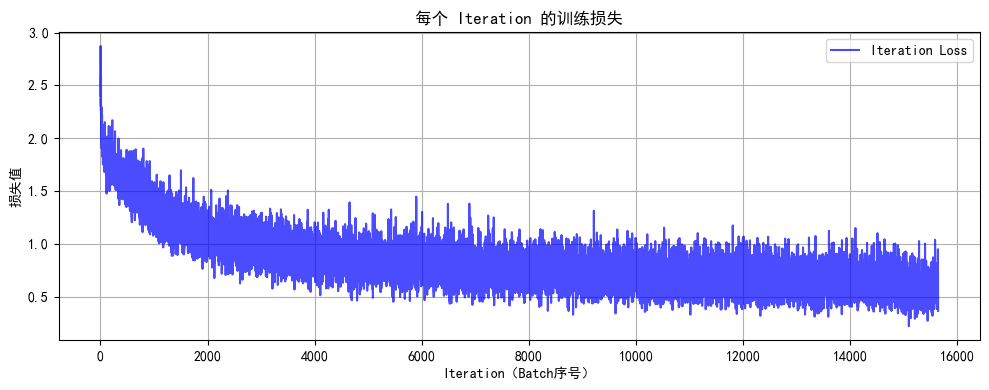

训练完成！最终测试准确率: 81.85%


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision  # 记得导入 torchvision，之前代码里用到了其功能但没导入

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 1. 数据预处理 
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 2. 加载CIFAR-10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=test_transform
)

# 3. 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# 4. 定义CNN模型的定义（替代原MLP）
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()  # 继承父类初始化
        
        # ---------------------- 第一个卷积块 ----------------------
        # 卷积层1：输入3通道（RGB），输出32个特征图，卷积核3x3，边缘填充1像素
        self.conv1 = nn.Conv2d(
            in_channels=3,       # 输入通道数（图像的RGB通道）
            out_channels=32,     # 输出通道数（生成32个新特征图）
            kernel_size=3,       # 卷积核尺寸（3x3像素）
            padding=1            # 边缘填充1像素，保持输出尺寸与输入相同
        )
        # 批量归一化层：对32个输出通道进行归一化，加速训练
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # ReLU激活函数：引入非线性，公式：max(0, x)
        self.relu1 = nn.ReLU()
        # 最大池化层：窗口2x2，步长2，特征图尺寸减半（32x32→16x16）
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # stride默认等于kernel_size
        
        # ---------------------- 第二个卷积块 ----------------------
        # 卷积层2：输入32通道（来自conv1的输出），输出64通道
        self.conv2 = nn.Conv2d(
            in_channels=32,      # 输入通道数（前一层的输出通道数）
            out_channels=64,     # 输出通道数（特征图数量翻倍）
            kernel_size=3,       # 卷积核尺寸不变
            padding=1            # 保持尺寸：16x16→16x16（卷积后）→8x8（池化后）
        )
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # 尺寸减半：16x16→8x8
        
        # ---------------------- 第三个卷积块 ----------------------
        # 卷积层3：输入64通道，输出128通道
        self.conv3 = nn.Conv2d(
            in_channels=64,      # 输入通道数（前一层的输出通道数）
            out_channels=128,    # 输出通道数（特征图数量再次翻倍）
            kernel_size=3,
            padding=1            # 保持尺寸：8x8→8x8（卷积后）→4x4（池化后）
        )
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()  # 复用激活函数对象（节省内存）
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # 尺寸减半：8x8→4x4
        
        # ---------------------- 全连接层（分类器） ----------------------
        # 计算展平后的特征维度：128通道 × 4x4尺寸 = 128×16=2048维
        self.fc1 = nn.Linear(
            in_features=128 * 4 * 4,  # 输入维度（卷积层输出的特征数）
            out_features=512          # 输出维度（隐藏层神经元数）
        )
        # Dropout层：训练时随机丢弃50%神经元，防止过拟合
        self.dropout = nn.Dropout(p=0.5)
        # 输出层：将512维特征映射到10个类别（CIFAR-10的类别数）
        self.fc2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        # 输入尺寸：[batch_size, 3, 32, 32]（batch_size=批量大小，3=通道数，32x32=图像尺寸）
        
        # ---------- 卷积块1处理 ----------
        x = self.conv1(x)       # 卷积后尺寸：[batch_size, 32, 32, 32]（padding=1保持尺寸）
        x = self.bn1(x)         # 批量归一化，不改变尺寸
        x = self.relu1(x)       # 激活函数，不改变尺寸
        x = self.pool1(x)       # 池化后尺寸：[batch_size, 32, 16, 16]（32→16是因为池化窗口2x2）
        
        # ---------- 卷积块2处理 ----------
        x = self.conv2(x)       # 卷积后尺寸：[batch_size, 64, 16, 16]（padding=1保持尺寸）
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)       # 池化后尺寸：[batch_size, 64, 8, 8]
        
        # ---------- 卷积块3处理 ----------
        x = self.conv3(x)       # 卷积后尺寸：[batch_size, 128, 8, 8]（padding=1保持尺寸）
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)       # 池化后尺寸：[batch_size, 128, 4, 4]
        
        # ---------- 展平与全连接层 ----------
        # 将多维特征图展平为一维向量：[batch_size, 128*4*4] = [batch_size, 2048]
        x = x.view(-1, 128 * 4 * 4)  # -1自动计算批量维度，保持批量大小不变
        
        x = self.fc1(x)           # 全连接层：2048→512，尺寸变为[batch_size, 512]
        x = self.relu3(x)         # 激活函数（复用relu3，与卷积块3共用）
        x = self.dropout(x)       # Dropout随机丢弃神经元，不改变尺寸
        x = self.fc2(x)           # 全连接层：512→10，尺寸变为[batch_size, 10]（未激活，直接输出logits）
        
        return x  # 输出未经过Softmax的logits，适用于交叉熵损失函数



# 初始化模型
model = CNN()
model = model.to(device)  # 将模型移至GPU（如果可用）


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,        # 指定要控制的优化器（这里是Adam）
    mode='min',       # 监测的指标是"最小化"（如损失函数）
    patience=3,       # 如果连续3个epoch指标没有改善，才降低LR
    factor=0.5,       # 降低LR的比例（新LR = 旧LR × 0.5）
    verbose=True      # 打印学习率调整信息
)

# ======================== TensorBoard 核心配置 ========================
# 创建 TensorBoard 日志目录（自动避免重复）
log_dir = "runs/cifar10_cnn_exp"
if os.path.exists(log_dir):
    version = 1
    while os.path.exists(f"{log_dir}_v{version}"):
        version += 1
    log_dir = f"{log_dir}_v{version}"
writer = SummaryWriter(log_dir)  # 初始化 SummaryWriter

# 5. 训练模型（整合 TensorBoard 记录）
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs, writer):
    model.train()
    all_iter_losses = []  
    iter_indices = []     
    global_step = 0       # 全局步骤，用于 TensorBoard 标量记录

    # （可选）记录模型结构：用一个真实样本走一遍前向传播，让 TensorBoard 解析计算图
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    writer.add_graph(model, images)  # 写入模型结构到 TensorBoard

    # （可选）记录原始训练图像：可视化数据增强前/后效果
    img_grid = torchvision.utils.make_grid(images[:8].cpu())  # 取前8张
    writer.add_image('原始训练图像（增强前）', img_grid, global_step=0)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # 记录迭代级损失
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(global_step + 1)  # 用 global_step 对齐

            # 统计准确率
            running_loss += iter_loss
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            # ======================== TensorBoard 标量记录 ========================
            # 记录每个 batch 的损失、准确率
            batch_acc = 100. * correct / total
            writer.add_scalar('Train/Batch Loss', iter_loss, global_step)
            writer.add_scalar('Train/Batch Accuracy', batch_acc, global_step)

            # 记录学习率（可选）
            writer.add_scalar('Train/Learning Rate', optimizer.param_groups[0]['lr'], global_step)

            # 每 200 个 batch 记录一次参数直方图（可选，耗时稍高）
            if (batch_idx + 1) % 200 == 0:
                for name, param in model.named_parameters():
                    writer.add_histogram(f'Weights/{name}', param, global_step)
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, global_step)

            # 每 100 个 batch 打印控制台日志（同原代码）
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch+1}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
                      f'| 单Batch损失: {iter_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')

            global_step += 1  # 全局步骤递增

        # 计算 epoch 级训练指标
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total

        # ======================== TensorBoard  epoch 标量记录 ========================
        writer.add_scalar('Train/Epoch Loss', epoch_train_loss, epoch)
        writer.add_scalar('Train/Epoch Accuracy', epoch_train_acc, epoch)

        # 测试阶段
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        wrong_images = []  # 存储错误预测样本（用于可视化）
        wrong_labels = []
        wrong_preds = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

                # 收集错误预测样本（用于可视化）
                wrong_mask = (predicted != target)
                if wrong_mask.sum() > 0:
                    wrong_batch_images = data[wrong_mask][:8].cpu()  # 最多存8张
                    wrong_batch_labels = target[wrong_mask][:8].cpu()
                    wrong_batch_preds = predicted[wrong_mask][:8].cpu()
                    wrong_images.extend(wrong_batch_images)
                    wrong_labels.extend(wrong_batch_labels)
                    wrong_preds.extend(wrong_batch_preds)

        # 计算 epoch 级测试指标
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test

        # ======================== TensorBoard 测试集记录 ========================
        writer.add_scalar('Test/Epoch Loss', epoch_test_loss, epoch)
        writer.add_scalar('Test/Epoch Accuracy', epoch_test_acc, epoch)

        # （可选）可视化错误预测样本
        if wrong_images:
            wrong_img_grid = torchvision.utils.make_grid(wrong_images)
            writer.add_image('错误预测样本', wrong_img_grid, epoch)
            # 写入错误标签文本（可选）
            wrong_text = [f"真实: {classes[wl]}, 预测: {classes[wp]}" 
                         for wl, wp in zip(wrong_labels, wrong_preds)]
            writer.add_text('错误预测标签', '\n'.join(wrong_text), epoch)

        # 更新学习率调度器
        scheduler.step(epoch_test_loss)

        print(f'Epoch {epoch+1}/{epochs} 完成 | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')

    # 关闭 TensorBoard 写入器
    writer.close()

    # 绘制迭代级损失曲线（同原代码）
    plot_iter_losses(all_iter_losses, iter_indices)
    return epoch_test_acc

# 6. 绘制迭代级损失曲线（同原代码，略）
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('每个 Iteration 的训练损失')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# （可选）CIFAR-10 类别名
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 7. 执行训练（传入 TensorBoard writer）
epochs = 20
print("开始使用CNN训练模型...")
print(f"TensorBoard 日志目录: {log_dir}")
print("训练后执行: tensorboard --logdir=runs 查看可视化")

final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs, writer)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

由于已近搭载了tensorboard，上述代码中一些之前可视化的冗余部分可以删除了

In [9]:
# 省略预处理、模型定义代码

# ======================== TensorBoard 核心配置 ========================
# 在使用tensorboard前需要先指定日志保存路径
log_dir = "runs/cifar10_cnn_exp" # 指定日志保存路径
if os.path.exists(log_dir): #检查刚才定义的路径是否存在
    version = 1 
    while os.path.exists(f"{log_dir}_v{version}"): # 如果路径存在且版本号一致
        version += 1 # 版本号加1
    log_dir = f"{log_dir}_v{version}" # 如果路径存在，则创建一个新版本
writer = SummaryWriter(log_dir) # 初始化SummaryWriter
print(f"TensorBoard 日志目录: {log_dir}") # 所以第一次是cifar10_cnn_exp、第二次是cifar10_cnn_exp_v1

# 5. 训练模型（整合 TensorBoard 记录）
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs, writer):
    model.train()
    global_step = 0  # 全局步骤，用于 TensorBoard 标量记录

    # 记录模型结构和训练图像
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    writer.add_graph(model, images)
    
    img_grid = torchvision.utils.make_grid(images[:8].cpu())
    writer.add_image('原始训练图像（增强前）', img_grid, global_step=0)

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # 统计准确率
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            # 记录每个 batch 的损失、准确率和学习率
            batch_acc = 100. * correct / total
            writer.add_scalar('Train/Batch Loss', loss.item(), global_step)
            writer.add_scalar('Train/Batch Accuracy', batch_acc, global_step)
            writer.add_scalar('Train/Learning Rate', optimizer.param_groups[0]['lr'], global_step)

            # 每 200 个 batch 记录一次参数直方图
            if (batch_idx + 1) % 200 == 0:
                for name, param in model.named_parameters():
                    writer.add_histogram(f'Weights/{name}', param, global_step)
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, global_step)

            global_step += 1

        # 计算 epoch 级训练指标
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        writer.add_scalar('Train/Epoch Loss', epoch_train_loss, epoch)
        writer.add_scalar('Train/Epoch Accuracy', epoch_train_acc, epoch)

        # 测试阶段
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        wrong_images = []
        wrong_labels = []
        wrong_preds = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

                # 收集错误预测样本
                wrong_mask = (predicted != target)
                if wrong_mask.sum() > 0:
                    wrong_batch_images = data[wrong_mask][:8].cpu()
                    wrong_batch_labels = target[wrong_mask][:8].cpu()
                    wrong_batch_preds = predicted[wrong_mask][:8].cpu()
                    wrong_images.extend(wrong_batch_images)
                    wrong_labels.extend(wrong_batch_labels)
                    wrong_preds.extend(wrong_batch_preds)

        # 计算 epoch 级测试指标
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        writer.add_scalar('Test/Epoch Loss', epoch_test_loss, epoch)
        writer.add_scalar('Test/Epoch Accuracy', epoch_test_acc, epoch)

        # 可视化错误预测样本
        if wrong_images:
            wrong_img_grid = torchvision.utils.make_grid(wrong_images)
            writer.add_image('错误预测样本', wrong_img_grid, epoch)
            wrong_text = [f"真实: {classes[wl]}, 预测: {classes[wp]}" 
                         for wl, wp in zip(wrong_labels, wrong_preds)]
            writer.add_text('错误预测标签', '\n'.join(wrong_text), epoch)

        # 更新学习率调度器
        scheduler.step(epoch_test_loss)
        print(f'Epoch {epoch+1}/{epochs} 完成 | 测试准确率: {epoch_test_acc:.2f}%')

    writer.close()
    return epoch_test_acc

# （可选）CIFAR-10 类别名
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 执行训练
epochs = 20
print("开始使用CNN训练模型...")
print("训练后执行: tensorboard --logdir=runs 查看可视化")

final_accuracy = train(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs, writer)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

TensorBoard 日志目录: runs/cifar10_cnn_exp_v2
开始使用CNN训练模型...
训练后执行: tensorboard --logdir=runs 查看可视化
Epoch    21: reducing learning rate of group 0 to 5.0000e-04.
Epoch 1/20 完成 | 测试准确率: 75.81%
Epoch 2/20 完成 | 测试准确率: 80.88%
Epoch 3/20 完成 | 测试准确率: 80.36%
Epoch 4/20 完成 | 测试准确率: 82.32%
Epoch 5/20 完成 | 测试准确率: 80.98%
Epoch 6/20 完成 | 测试准确率: 81.43%
Epoch 7/20 完成 | 测试准确率: 81.86%
Epoch    28: reducing learning rate of group 0 to 2.5000e-04.
Epoch 8/20 完成 | 测试准确率: 81.89%
Epoch 9/20 完成 | 测试准确率: 82.69%
Epoch 10/20 完成 | 测试准确率: 83.66%
Epoch 11/20 完成 | 测试准确率: 83.29%
Epoch 12/20 完成 | 测试准确率: 82.99%
Epoch 13/20 完成 | 测试准确率: 83.11%
Epoch    34: reducing learning rate of group 0 to 1.2500e-04.
Epoch 14/20 完成 | 测试准确率: 83.58%
Epoch 15/20 完成 | 测试准确率: 83.79%
Epoch 16/20 完成 | 测试准确率: 83.88%
Epoch 17/20 完成 | 测试准确率: 83.89%
Epoch 18/20 完成 | 测试准确率: 84.08%
Epoch 19/20 完成 | 测试准确率: 84.25%
Epoch 20/20 完成 | 测试准确率: 84.21%
训练完成！最终测试准确率: 84.21%


上述这段代码，由于我单独拎出来了，没有重新初始化cnn，如果二次运行就会创建一个新的目录，并且接着之前的运行

tensorboard的代码还有有一定的记忆量，实际上深度学习的经典代码都是类似于八股文，看多了就习惯了，难度远远小于考研数学等需要思考的内容

实际上对目前的ai而言，你只需要先完成最简单的demo，然后让他给你加上tensorboard需要打印的部分即可。---核心是弄懂tensorboard可以打印什么信息，以及如何看可视化后的结果，把ai当成记忆大师用到的时候通过它来调取对应的代码即可。